In [1]:
pip install opencv-python numpy pandas scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2
import os
import numpy as np
cwd = os.getcwd()
video_path = os.path.join(cwd, 'store.mp4')
cap = cv2.VideoCapture(video_path)

frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

cap.release()
print(f'Total number of frames extracted: {len(frames)}')

Total number of frames extracted: 1283


In [4]:
prototxt_path = os.path.join(cwd, 'deploy.prototxt')
model_path = os.path.join(cwd, 'mobilenet_iter_73000.caffemodel')
net = cv2.dnn.readNetFromCaffe(prototxt_path, model_path)

def detect_people(frame):
    h, w = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(frame, (300, 300)), 0.007843, (300, 300), 127.5)
    net.setInput(blob)
    detections = net.forward()
    people = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.2:  # Confidence threshold
            idx = int(detections[0, 0, i, 1])
            if idx == 15:  # Class label for person
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")
                people.append((startX, startY, endX, endY))
    return people

In [15]:
def draw_bounding_boxes(frame, people):
    for (startX, startY, endX, endY) in people:
        cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 255, 0), 2)
    return frame
for frame in frames:
    people = detect_people(frame)
    frame_with_boxes = draw_bounding_boxes(frame, people)
    cv2.imshow('Video with Bounding Boxes', frame_with_boxes)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

In [9]:
from collections import defaultdict

# Simple centroid tracking
tracks = defaultdict(list)
track_id = 0

for frame in frames:
    people = detect_people(frame)
    for (startX, startY, endX, endY) in people:
        centroid = (int((startX + endX) / 2), int((startY + endY) / 2))
        tracks[track_id].append(centroid)
        track_id += 1

In [20]:
import numpy as np

grid_size = (5, 5)  # Adjust grid size as needed
footfall = np.zeros(grid_size)

for track in tracks.values():
    for (x, y) in track:
        grid_x = x // (frame.shape[1] // grid_size[0])
        grid_y = y // (frame.shape[0] // grid_size[1])
        footfall[grid_y, grid_x] += 1

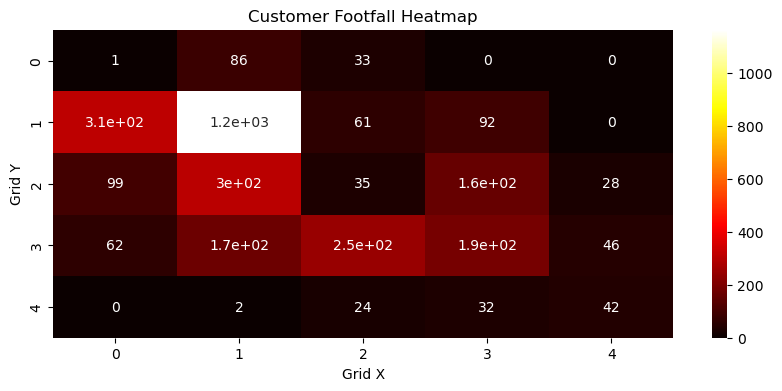

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.heatmap(footfall, cmap='hot', annot=True)
plt.title('Customer Footfall Heatmap')
plt.xlabel('Grid X')
plt.ylabel('Grid Y')
plt.show()
